In [6]:
#pip install fedot==0.5

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: attrs>=19.2.0 in c:\users\anubhav\anaconda3\lib\site-packages (from pytest>=6.2.*->fedot==0.5) (19.3.0)



In [5]:
#pip install tensorflow==2.5.2

Note: you may need to restart the kernel to use updated packages.


In [4]:
#pip install numpy>=1.20.0

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Additional imports are required
import os 

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

import warnings
warnings.filterwarnings('ignore')

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

#### The below function trains a linear autoregressive model, which use 2 predictors to give a forecast and the return model provides fitted linear regression model

In [87]:
def autoregression(dataframe):

    
    
    vals = dataframe['Values']
    
    
    lagged_dataframe = pd.concat([vals.shift(2), vals.shift(1), vals], axis=1)
    
    
    lagged_dataframe.columns = ['Predictor 1', 'Predictor 2', 'Target']
    
    # Drop na rows (first two rows)
    lagged_dataframe.dropna(inplace=True)
    
    # Display first five rows
    print(lagged_dataframe.head(4))
    
    # Get linear model to train
    model = LinearRegression()
    
    # Prepare features and target for model
    x_train = lagged_dataframe[['Predictor 1', 'Predictor 2']]
    y_train = lagged_dataframe['Target']
    
    # Fit the model
    model.fit(x_train, y_train)
    return model

In [88]:
import csv
df = pd.read_csv('C:\\Users\\ANUBHAV\\Downloads\\FP-2\\Oil_prod.csv')

In [89]:
# Get fitted model
fitted_model = autoregression(df)

   Predictor 1  Predictor 2  Target
2       5848.0       5871.0    5883
3       5871.0       5883.0    5859
4       5883.0       5859.0    5924
5       5859.0       5924.0    5915


As seen in the example, autoregressive models are necessary to model the dependence between the constituents of a time series. We utilised linear regression to approximate the relationship, although nonlinear models (such as random forest) can also be used.

These models, however, are not directly employed in the framework. They're kept in containers called "nodes."

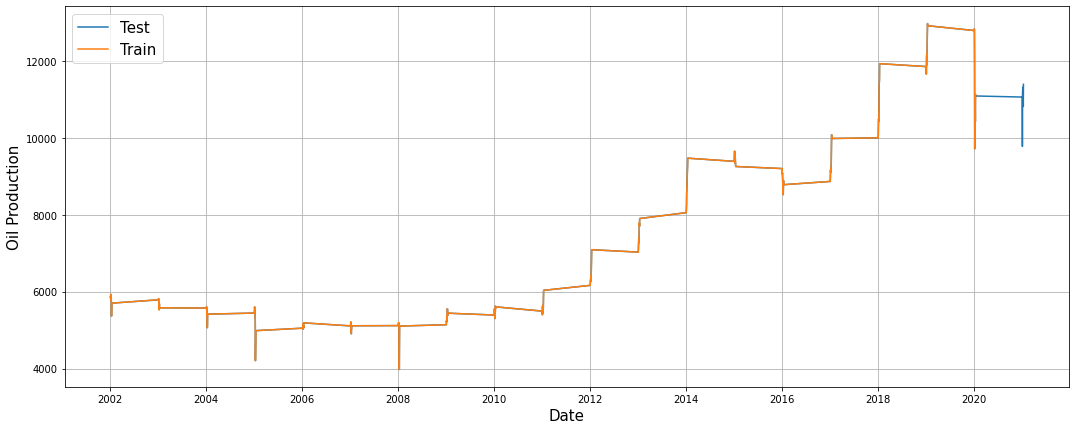

In [22]:
# Read the file
df['Date'] = pd.to_datetime(df['Date'])

# Specify forecast length
len_forecast = 10

# Got train, test parts, and the entire data
true_values = np.array(df['Values'])
train_array = true_values[:-len_forecast]
test_array = true_values[-len_forecast:]

plt.plot(df['Date'], true_values, label = 'Test')
plt.plot(df['Date'][:-len_forecast], train_array, label = 'Train')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Oil Production', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

In [30]:
def make_forecast(train_data, len_forecast: int, window_size: int, final_model: str = 'ridge'):
    """
    Function for predicting values in a time series
    
    :param train_data: one-dimensional numpy array to train pipeline
    :param len_forecast: amount of values for predictions
    :param window_size: moving window size
    :param final_model: model in the root node

    :return predicted_values: numpy array, forecast of model
    """
    
    # Here we define which task should we use, here we also define two main forecast length
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=len_forecast))

    # Prepare data to train the model
    train_input = InputData(idx=np.arange(0, len(train_data)),
                            features=train_data,
                            target=train_data,
                            task=task,
                            data_type=DataTypesEnum.ts)

    # Prepare input data for prediction part
    start_forecast = len(train_data)
    end_forecast = start_forecast + len_forecast
    # Create forecast indices 
    forecast_idx = np.arange(start_forecast, end_forecast)
    predict_input = InputData(idx=forecast_idx,
                              features=train_data,
                              target=test_data,
                              task=task,
                              data_type=DataTypesEnum.ts)
    
    # Create a pipeline "lagged -> <final_model>" 
    node_lagged = PrimaryNode('lagged')
    
    # Define parameters to certain node 
    node_lagged.custom_params = {'window_size': window_size}
    node_ridge = SecondaryNode(final_model, nodes_from=[node_lagged])
    ridge_pipeline = Pipeline(node_ridge)

    # Fit pipeline
    ridge_pipeline.fit(train_input)

    # Predict. Pipeline return OutputData object 
    predicted_output = ridge_pipeline.predict(predict_input)

    # Convert forecasted values into one-dimensional array
    forecast = np.ravel(np.array(predicted_output.predict))

    return forecast

In [23]:
# Make predictions
predicted_values = make_forecast(train_data=train_array, 
                                 len_forecast=10,
                                 window_size=400,
                                 final_model='ridge')

In [24]:
def plot_results(actual_time_series, predicted_values, len_train_data, y_name = 'Parameter'):
    """
    Function for drawing plot with predictions
    
    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """
    
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15)
    plt.grid()
    plt.show()

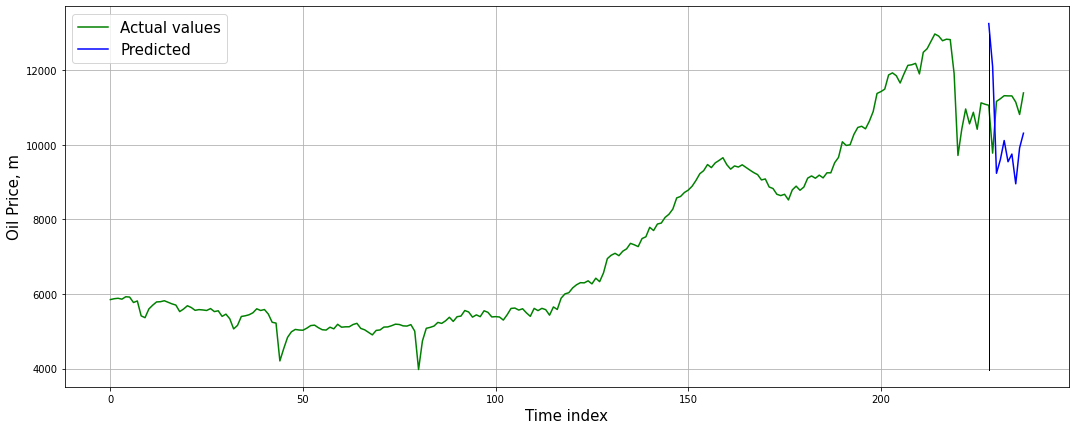

Mean absolute error: 1676.195


In [25]:
# Plot predictions and true values
plot_results(actual_time_series=true_values,
             predicted_values=predicted_values, 
             len_train_data=len(train_array),
             y_name='Oil Price, m')

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(test_array, predicted_values):.3f}')

In [38]:
predicted_values = make_forecast(train_data = train_array, 
                                 len_forecast = 100,
                                 window_size = 400)


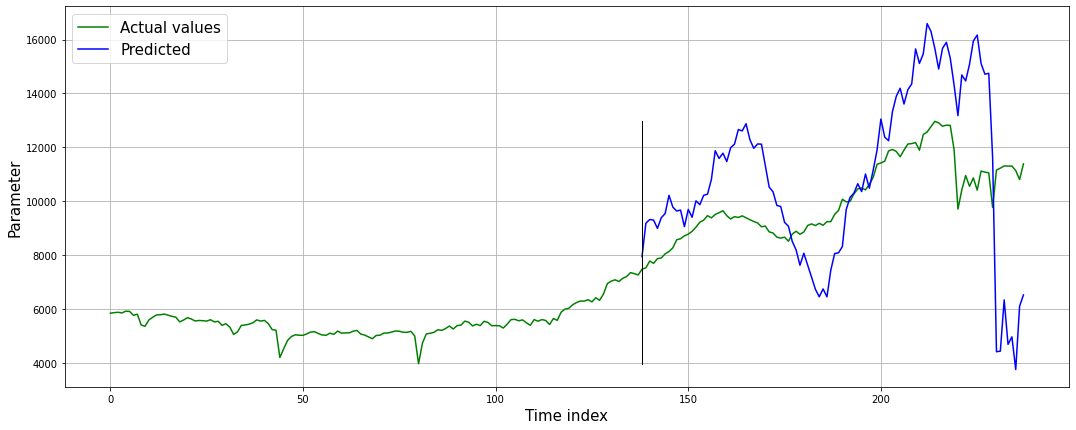

In [39]:
plot_results(actual_time_series = true_values,
             predicted_values = predicted_values, 
             len_train_data = len(train_data))

In [63]:
# First level
node_lagged_1 = PrimaryNode('lagged')
node_lagged_1.custom_params = {'window_size': 3}
node_lagged_2 = PrimaryNode('lagged')
node_lagged_2.custom_params = {'window_size': 450}

# Second level
node_knnreg = SecondaryNode('knnreg', nodes_from=[node_lagged_1])
node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged_2])

# Third level - root node
node_final = SecondaryNode('ridge', nodes_from=[node_knnreg, node_ridge])
complex_pipeline = Pipeline(node_final)

In [64]:
# Here we define which task should we use, here we also define two main forecast length
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=10))

# Prepare data to train the model
train_input = InputData(idx=np.arange(0, len(train_array)),
                        features=train_array,
                        target=train_array,
                        task=task,
                        data_type=DataTypesEnum.ts)

# Prepare input data for prediction part
start_forecast = len(train_array)
end_forecast = start_forecast + len_forecast
# Create forecast indices 
forecast_idx = np.arange(start_forecast, end_forecast)
predict_input = InputData(idx=forecast_idx,
                          features=train_array,
                          target=None,
                          task=task,
                          data_type=DataTypesEnum.ts)

In [65]:
size_train = np.array(train_input)
print(size_train.shape)

()


In [66]:
# Fit pipeline
complex_pipeline.fit(train_input)

OutputData(idx=array([208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218]), features=array([[11989.2       , 11953.6       , 12114.8       , 12241.8       ,
        12427.6       , 12476.8       , 12603.6       , 12741.6       ,
        12772.8       , 12832.8       , 12141.00000394, 12178.99997532,
        11896.00015632, 12475.00001018, 12572.00004908, 12771.00005533,
        12966.00003073, 12910.00000879, 12784.99997696, 12825.99999086],
       [12068.8       , 12204.2       , 12367.8       , 12585.        ,
        12679.6       , 12665.6       , 12792.4       , 12781.8       ,
        12621.8       , 12046.        , 12178.99994843, 11896.00012052,
        12474.99987234, 12572.00005329, 12770.99999984, 12965.99998964,
        12909.99997276, 12784.99998655, 12826.0000161 , 12815.99984722],
       [12155.        , 12322.6       , 12581.8       , 12672.        ,
        12722.2       , 12676.6       , 12762.4       , 12582.        ,
        12007.        , 11564.8       , 11896.

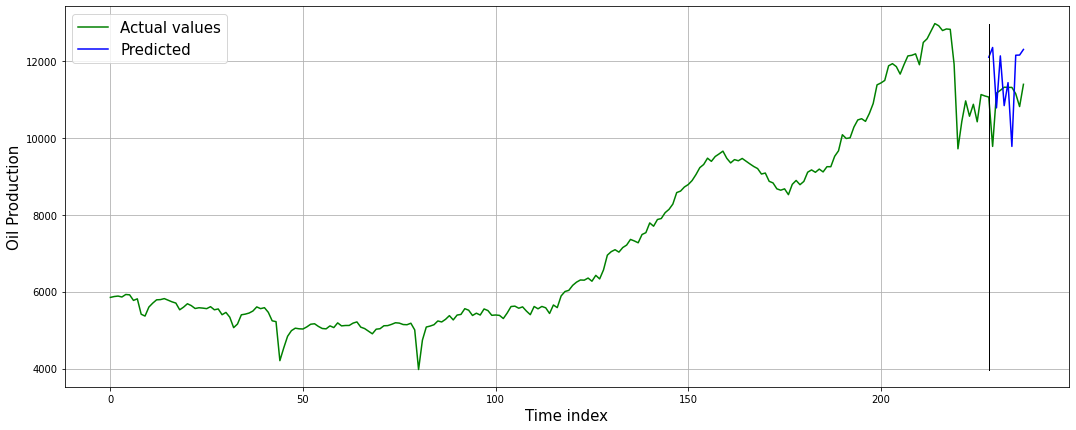

Mean absolute error: 1027.108


In [67]:
# Predict. Pipeline return OutputData object 
predicted_output = complex_pipeline.predict(predict_input)

# Convert forecasted values into one-dimensional array
predicted_values = np.ravel(np.array(predicted_output.predict))

# Plot predictions and true values
plot_results(actual_time_series = true_values,
             predicted_values = predicted_values, 
             len_train_data = len(train_array),
             y_name = 'Oil Production')

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(test_array, predicted_values):.3f}')

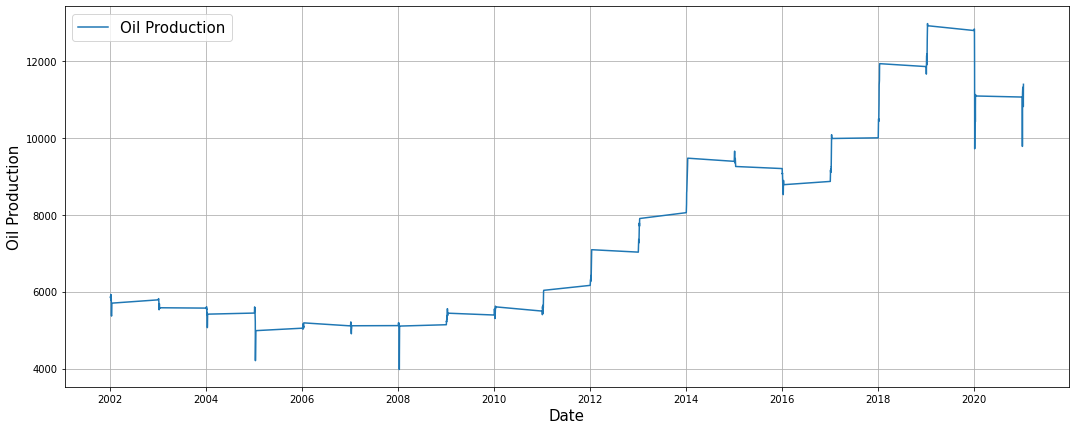

In [70]:
# Plot two time series
plt.plot(df['Date'], df['Values'], label = 'Oil Production')
#plt.plot(df['Date'], df['Neighboring level'], label = 'sea height from point with coordinates 10°N 121°W')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Oil Production', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

In [82]:
# Specify forecast length
len_forecast = 10
task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=len_forecast))

# Got train, test parts, and the entire data
true_values = np.array(df['Values'])
train_array = true_values[:-len_forecast]
test_array = true_values[-len_forecast:]

# Data for lagged transformation
train_lagged = InputData(idx=np.arange(0, len(train_array)),
                         features=train_array,
                         target=train_array,
                         task=task,
                         data_type=DataTypesEnum.ts)
start_forecast = len(train_array)
end_forecast = start_forecast + len_forecast
predict_lagged = InputData(idx=np.arange(start_forecast, end_forecast),
                           features=train_array,
                           target=test_array,
                           task=task,
                           data_type=DataTypesEnum.ts)

In [83]:
exog_arr = np.array(df['Values'])
exog_train = exog_arr[:-len_forecast]
exog_test = exog_arr[-len_forecast:]

# Data for exog operation
train_exog = InputData(idx=np.arange(0, len(exog_train)),
                       features=exog_train,
                       target=train_array,
                       task=task,
                       data_type=DataTypesEnum.ts)
start_forecast = len(exog_train)
end_forecast = start_forecast + len_forecast
predict_exog = InputData(idx=np.arange(start_forecast, end_forecast),
                          features=exog_test,
                          target=test_array,
                          task=task,
                          data_type=DataTypesEnum.ts)

In [84]:
from fedot.core.data.multi_modal import MultiModalData

train_dataset = MultiModalData({
    'lagged': train_lagged,
    'exog_ts': train_exog
})

predict_dataset = MultiModalData({
    'lagged': predict_lagged,
    'exog_ts': predict_exog
})

In [85]:
# Create a pipeline with different data sources in th nodes 
node_lagged = PrimaryNode('lagged')
node_exog = PrimaryNode('exog_ts')
node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged, node_exog])
exog_pipeline = Pipeline(node_ridge)

# Fit it
exog_pipeline.fit(train_dataset)

# Predict
predicted = exog_pipeline.predict(predict_dataset)
predicted_values = np.ravel(np.array(predicted.predict))

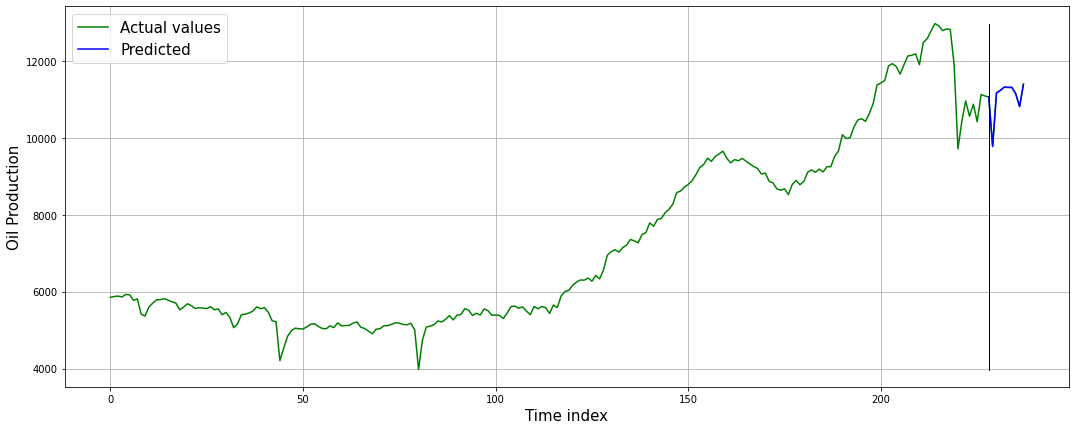

Mean absolute error: 0.000


In [86]:
# Plot predictions and true values
plot_results(actual_time_series = true_values,
             predicted_values = predicted_values, 
             len_train_data = len(train_array),
             y_name = 'Oil Production')

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(test_array, predicted_values):.3f}')